# Africa's Political Conflicts

In [118]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
cv = sc.textFile("conflicts.csv")
cv.count()

170579

In [119]:
## fonction
def splitter(lineOfText): 
     words = lineOfText.split(" ") 
     return len(words) 
def aggregate(numWordsLine1, numWordsLineNext): 
     totalWords = numWordsLine1 + numWordsLineNext 
     return totalWords
#Number of words
wordperline = cv.map(splitter)
totwords = wordperline.reduce(aggregate)
totwords

7224132

In [120]:
spark = SparkSession \
    .builder \
    .appName("Python Spark create RDD example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
dataframe = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').\
                load("conflicts.csv")
rdd = spark.read.option("delimiter", ",").csv(cv, header='true', inferSchema='true').rdd
#display part of the data 
dataframe.show(3)

+---+---+----------+----------+--------------------+--------------------+-------------+--------------------+-------------+-----------+---------------+-------+---------+------------+-----------+-----------------+--------------------+----------+
|_c0|ISO|EVENT_DATE|EVENT_TYPE|      SUB_EVENT_TYPE|              ACTOR1|ASSOC_ACTOR_1|              ACTOR2|ASSOC_ACTOR_2|INTERACTION|         REGION|COUNTRY|   ADMIN1|      ADMIN2|   LOCATION|           SOURCE|               NOTES|FATALITIES|
+---+---+----------+----------+--------------------+--------------------+-------------+--------------------+-------------+-----------+---------------+-------+---------+------------+-----------+-----------------+--------------------+----------+
|  0| 12|2010-12-20|   Battles|         Armed clash|Military Forces o...|         null|Unidentified Arme...|         null|         13|Northern Africa|Algeria|Boumerdes|       Ammal|Ait Dahmane|      TSA Algerie|A militant was ca...|         0|
|  1| 12|2010-12-25|    

In [121]:
#remove the first two columns
#display the structure of the data
dataframe = dataframe.drop(dataframe.columns[0])
dataframe.printSchema()

root
 |-- ISO: integer (nullable = true)
 |-- EVENT_DATE: string (nullable = true)
 |-- EVENT_TYPE: string (nullable = true)
 |-- SUB_EVENT_TYPE: string (nullable = true)
 |-- ACTOR1: string (nullable = true)
 |-- ASSOC_ACTOR_1: string (nullable = true)
 |-- ACTOR2: string (nullable = true)
 |-- ASSOC_ACTOR_2: string (nullable = true)
 |-- INTERACTION: integer (nullable = true)
 |-- REGION: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- ADMIN1: string (nullable = true)
 |-- ADMIN2: string (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- SOURCE: string (nullable = true)
 |-- NOTES: string (nullable = true)
 |-- FATALITIES: integer (nullable = true)



In [143]:
dataframe.registerTempTable("conflicts")
fatalities = sqlContext.sql("""
SELECT YEAR(EVENT_DATE) AS year, SUM(FATALITIES) AS fatalities
FROM conflicts
GROUP BY YEAR(EVENT_DATE)
ORDER BY YEAR(EVENT_DATE)""")
fatalities.show()

+----+----------+
|year|fatalities|
+----+----------+
|2010|       262|
|2011|     21478|
|2012|     18588|
|2013|     30228|
|2014|     40279|
|2015|     37017|
|2016|     31653|
|2017|     31162|
|2018|     28445|
|2019|     29188|
|2020|     30263|
+----+----------+



In [98]:
#we filter out the strings containing "Tunisia".
tunisia_filter = rdd.filter(lambda x: 'Tunisia' in x[11])
tunisia_filter.take(3)

[Row(_c0=146685, ISO=788, EVENT_DATE='2010-12-18', EVENT_TYPE='Protests', SUB_EVENT_TYPE='Peaceful protest', ACTOR1='Protesters (Tunisia)', ASSOC_ACTOR_1=None, ACTOR2=None, ASSOC_ACTOR_2=None, INTERACTION=60, REGION='Northern Africa', COUNTRY='Tunisia', ADMIN1='Sidi Bou Zid', ADMIN2='Sidi Bouzid Est', LOCATION='Sidi Bouzid', SOURCE='AFP', NOTES='Small protest after man set himself on fire the day before in protest at police abuse', FATALITIES=0),
 Row(_c0=146686, ISO=788, EVENT_DATE='2010-12-19', EVENT_TYPE='Protests', SUB_EVENT_TYPE='Peaceful protest', ACTOR1='Protesters (Tunisia)', ASSOC_ACTOR_1=None, ACTOR2=None, ASSOC_ACTOR_2=None, INTERACTION=60, REGION='Northern Africa', COUNTRY='Tunisia', ADMIN1='Sidi Bou Zid', ADMIN2='Sidi Bouzid Est', LOCATION='Sidi Bouzid', SOURCE='AFP', NOTES='Wave of protests after man sets himself alight', FATALITIES=0),
 Row(_c0=146687, ISO=788, EVENT_DATE='2010-12-22', EVENT_TYPE='Protests', SUB_EVENT_TYPE='Peaceful protest', ACTOR1='Protesters (Tunisia)

In [53]:
# we form a key value pair and map every string with a value of Tunisia.
tunisia_map = tunisia_filter.map(lambda x: (x[11], x[2]))
tunisia_map.take(3)

[('Tunisia', '2010-12-18'),
 ('Tunisia', '2010-12-19'),
 ('Tunisia', '2010-12-22')]

Text(0.5, 1.0, 'Movie genres available on these streaming platforms')

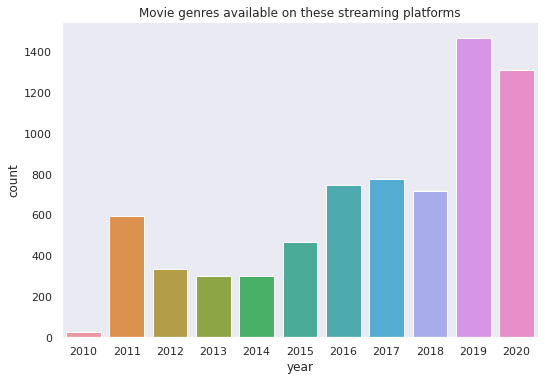

In [83]:
rddColumns = ["country","year"]
df = tunisia_map.toDF(rddColumns).toPandas()
df['year'] = pd.to_datetime(df['year'], errors='coerce')
df['year'] = df['year'].dt.year
sns.catplot(x="year", data=df, aspect=1.5,kind="count")
plt.title('Movie genres available on these streaming platforms')

In [8]:
#we can also check if the RDD is cached or not.
caching = cv.persist().is_cached 
print ( "Words got chached > %s" % (caching))

Words got chached > True


In [59]:
#we can select and show the rows with select and the names of the features
#for example we can show Province compared with Confirmed
dataframe.select('INTERACTION','FATALITIES').show(10)

+-----------+----------+
|INTERACTION|FATALITIES|
+-----------+----------+
|         13|         0|
|         15|         0|
|         12|         2|
|         50|         0|
|         15|         0|
|         15|         0|
|         15|         0|
|         15|         0|
|         13|         1|
|         30|         0|
+-----------+----------+
only showing top 10 rows



In [60]:
#show data sorted by Fatalities
dataframe.sort("FATALITIES",ascending=False).show(3)			

+------+---+----------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+-----------+---------------+-----------+-------+-------+--------+-----------------+--------------------+----------+
|   _c0|ISO|EVENT_DATE|          EVENT_TYPE|      SUB_EVENT_TYPE|              ACTOR1|ASSOC_ACTOR_1|              ACTOR2|       ASSOC_ACTOR_2|INTERACTION|         REGION|    COUNTRY| ADMIN1| ADMIN2|LOCATION|           SOURCE|               NOTES|FATALITIES|
+------+---+----------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+-----------+---------------+-----------+-------+-------+--------+-----------------+--------------------+----------+
|128944|728|2011-08-18|Violence against ...|              Attack|Murle Ethnic Mili...|         null|Civilians (South ...|                null|         47| Eastern Africa|South Sudan|Jonglei|   Uror|   Pieri|Small Arms Survey|C

In [61]:
# Countries With no deaths in 2011
sqlContext = SQLContext(sc)
dataframe.registerTempTable("conflicts")	#save the data as a table	
#display Country last updated at 2020-12-07 05:26:14 where Deaths are null.
countries_with_no_deaths= sqlContext.sql("SELECT DISTINCT Country FROM conflicts where EVENT_DATE like '%2011%' and FATALITIES=0")
countries_with_no_deaths.show(10)

+-----------------+
|          Country|
+-----------------+
|             Chad|
|          Senegal|
|          Eritrea|
|         Djibouti|
|           Malawi|
|      Ivory Coast|
|           Rwanda|
|            Sudan|
|          Algeria|
|Equatorial Guinea|
+-----------------+
only showing top 10 rows



In [62]:
# Recovered cases statistics 
dataframe.describe('FATALITIES').show()		

+-------+------------------+
|summary|        FATALITIES|
+-------+------------------+
|  count|            170578|
|   mean|1.7503019146666041|
| stddev| 9.874958100076823|
|    min|                 0|
|    max|               750|
+-------+------------------+



In [63]:
# Recovered cases statistics 
dataframe.describe('INTERACTION').show()		

+-------+------------------+
|summary|       INTERACTION|
+-------+------------------+
|  count|            170578|
|   mean|34.586605541160054|
| stddev| 19.07524097084693|
|    min|                10|
|    max|                88|
+-------+------------------+



In [66]:
dataframe.filter(dataframe.EVENT_DATE.contains("2008")).count()

0

In [67]:
dataframe.filter(dataframe.EVENT_DATE.contains("2011")).count()

8127

In [68]:
dataframe.filter(dataframe.EVENT_DATE.contains("2014")).count()

16547

In [69]:
dataframe.filter(dataframe.EVENT_DATE.contains("2018")).count()

19460

In [89]:
import seaborn as sns
df = dataframe.toPandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170578 entries, 0 to 170577
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _c0             170578 non-null  int32 
 1   ISO             170578 non-null  int32 
 2   EVENT_DATE      170578 non-null  object
 3   EVENT_TYPE      170578 non-null  object
 4   SUB_EVENT_TYPE  170578 non-null  object
 5   ACTOR1          170578 non-null  object
 6   ASSOC_ACTOR_1   44078 non-null   object
 7   ACTOR2          120235 non-null  object
 8   ASSOC_ACTOR_2   31630 non-null   object
 9   INTERACTION     170578 non-null  int32 
 10  REGION          170578 non-null  object
 11  COUNTRY         170578 non-null  object
 12  ADMIN1          170578 non-null  object
 13  ADMIN2          170497 non-null  object
 14  LOCATION        170578 non-null  object
 15  SOURCE          170578 non-null  object
 16  NOTES           170569 non-null  object
 17  FATALITIES      170578 non-nu

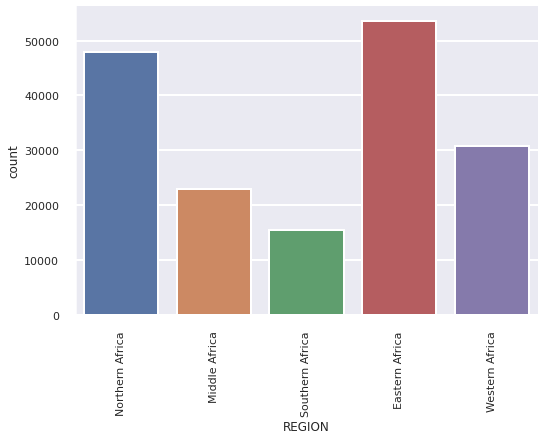

In [21]:
sns.set()
sns.set_context("poster", font_scale=0.5, rc={"lines.linewidth": 15})
ax = sns.catplot(x="REGION", data=df, aspect=1.5,kind="count")
ax.set_xticklabels(rotation=90)

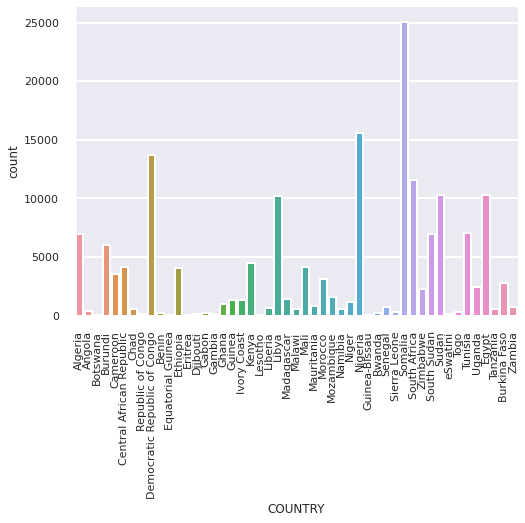

In [22]:
sns.set()
sns.set_context("poster", font_scale=0.5, rc={"lines.linewidth": 15})
ax = sns.catplot(x="COUNTRY", data=df, aspect=1.5,kind="count")
ax.set_xticklabels(rotation=90)

In [90]:
yearRDD=rdd.flatMap(lambda x : x[9].split(",")). map ( lambda x : ( x , 1 )).reduceByKey(lambda a, b: a + b).sortBy(lambda x : x[1] , ascending=False)
rddColumns = ["genre","count"]
yearRDD = yearRDD.map(lambda n:(str(n[0]), int(n[1]) ) ).filter(lambda n: n[0]!="unknown" ).toDF(rddColumns).toPandas()
yearRDD.head(5)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 137.0 failed 1 times, most recent failure: Lost task 1.0 in stage 137.0 (TID 538, localhost.localdomain, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/apache-spark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/opt/apache-spark/python/lib/pyspark.zip/pyspark/worker.py", line 595, in process
    out_iter = func(split_index, iterator)
  File "/opt/apache-spark/python/pyspark/rdd.py", line 2596, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/apache-spark/python/pyspark/rdd.py", line 2596, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/apache-spark/python/pyspark/rdd.py", line 425, in func
    return f(iterator)
  File "/opt/apache-spark/python/pyspark/rdd.py", line 1946, in combineLocally
    merger.mergeValues(iterator)
  File "/opt/apache-spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 238, in mergeValues
    for k, v in iterator:
  File "/opt/apache-spark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-90-b4c66e61d473>", line 1, in <lambda>
AttributeError: 'int' object has no attribute 'split'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1209)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1215)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2120)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2139)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2164)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:168)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/apache-spark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/opt/apache-spark/python/lib/pyspark.zip/pyspark/worker.py", line 595, in process
    out_iter = func(split_index, iterator)
  File "/opt/apache-spark/python/pyspark/rdd.py", line 2596, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/apache-spark/python/pyspark/rdd.py", line 2596, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/apache-spark/python/pyspark/rdd.py", line 425, in func
    return f(iterator)
  File "/opt/apache-spark/python/pyspark/rdd.py", line 1946, in combineLocally
    merger.mergeValues(iterator)
  File "/opt/apache-spark/python/lib/pyspark.zip/pyspark/shuffle.py", line 238, in mergeValues
    for k, v in iterator:
  File "/opt/apache-spark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-90-b4c66e61d473>", line 1, in <lambda>
AttributeError: 'int' object has no attribute 'split'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1209)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1215)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
dfpandas['EVENT_DATE'] = pd.to_datetime(dfpandas['EVENT_DATE'], errors='coerce')
dfpandas['year'] = dfpandas['EVENT_DATE'].dt.year